In [119]:
import pandas as pd
from google.cloud import storage
import spacy
from collections import defaultdict
import re
import string
from io import StringIO, BytesIO
from urllib.request import Request, urlopen
from functools import reduce, partial
import pickle
import numpy as np
from time import time

from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')


import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


nlp = spacy.load('en_core_web_sm', parser=True)


def read_from_bucket(bucket):

    """
    This concatenates all csv files in a bucket together.
    Returns a single dataframe.
    """
    
    frames = []
    files  = list(bucket.list_blobs())
    for file in files:
        blob = bucket.blob(file.name)
        data = pd.read_csv(BytesIO(blob.download_as_string()), encoding='utf-8')
        frames.append(data)
    data = pd.concat(frames)
    return data


def return_politician_handles(option='list'):
    req = Request('https://www.politics-social.com/api/list/csv/followers', headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    s=str(webpage,'utf-8')
    data = StringIO(s) 
    df=pd.read_csv(data)
    df['Name'] = df['Name'].apply(lambda x: x.rstrip())
    df['Screen name'] = df['Screen name'].apply(lambda x: x[1:])
    politician_handles = df['Screen name']
    print('Politician twitter handles imported.\n')

    if option=='list':
        return politician_handles
    else:
        return df
    
    
    
def deEmojify(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)




def remove_hyperlinks(text):
    text = re.sub(r"http\S+", "", text)
    return text

def remove_punctuation(text):
    text = re.sub(r'[)(|!%?@#*,/:;…-]', ' ', text)
    text = re.sub(r'&amp', 'and', text)
    return text

def fix_apostrophes(text):
    text = re.sub(r'’', "'", text)
    return text

def remove_whitespace(text):
    text = re.sub(r'[\t\n\r]', ' ', text)
    return text

def normalize_whitespace(text):
    text = re.sub(r' +', ' ', text)
    return text

def strip_space(text):
    return text.strip()

def end_with_fullstop(text):
#     print(text)
    if len(text)>0 and text[-1]=='.':
        return text
    else:
        return text + '.'

def string_process(text):
    func_list = [
        deEmojify,
        remove_hyperlinks,
        remove_punctuation,
        fix_apostrophes,
        remove_whitespace,
        normalize_whitespace,
        strip_space,
        end_with_fullstop
    ]
    text = reduce(lambda x, func: func(x), func_list, text)
    return text.lower()


def tokenize(text):
    doc = nlp(text)
    tokens = [token for token in doc if not token.is_stop]
    tokens = [token for token in tokens if token.pos_ not in ['PUNCT','SYM','NUM','PART','SPACE']]
    tokens = [token for token in tokens if token.text not in [
        "n't","'h",'m','wh','%','rt',"'s","'ve","'ll",'’re',
        "'m",'&',"'ve","'re",'’ve','’ll','’s','’m','n’t','s.','c.','f.','m.'
    ]]
    tokens = [token.lemma_ for token in tokens]
    return tokens

## Import data

I have a GCP bucket containing a dump of scraped tweets of UK politicians. I can pull in the data from there.

In [2]:
bucket_name = 'uk-gov-tweets-14289'
storage_client = storage.Client.from_service_account_json('creds.json')
bucket = storage_client.get_bucket(bucket_name)
data = read_from_bucket(bucket=bucket)
data.head()

,id,text,created,user
0,1442904820264804354,"Very sorry to hear of the death of Roger Hunt,...",2021-09-28 17:31:31+00:00,BorisJohnson
1,1442895964386197507,I'd urge everyone to go about their business i...,2021-09-28 16:56:20+00:00,BorisJohnson
2,1442513824821751809,RT @RishiSunak: When we said we’d do whatever ...,2021-09-27 15:37:51+00:00,BorisJohnson
3,1442062761761062920,It’s 75 years since the foundation of the Nati...,2021-09-26 09:45:29+00:00,BorisJohnson
4,1442031671910486016,No words can adequately do justice to the debt...,2021-09-26 07:41:56+00:00,BorisJohnson


## Text tokens

A set of pre-tokenized tweets to save the time processing all of the text again.

When importing, the list of tokens get converted to strings so ast_literal is used to convert back to lists.

In [22]:
import ast

corpus = pd.read_csv('tokenized_tweets.csv')
corpus.drop('Unnamed: 0', axis=1, inplace=True)
corpus['text'] = corpus['text'].apply(ast.literal_eval)
corpus = list(corpus['text'])

## Doc2Vec modelling

In [29]:
import multiprocessing

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [30]:
cores = multiprocessing.cpu_count()

Initialise the model.

In [31]:
d2v_model = Doc2Vec(
    dm=1,
    vector_size=100,
    window=10,
    negative=5,
    hs=0,
    min_count=2,
    sample=0,
    epochs=20,
    workers=cores-1,
    alpha=0.05,
    comment='alpha=0.05')

INFO - 12:16:10: Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d100,n5,w10,mc2,t3)', 'datetime': '2021-10-09T12:16:10.300750', 'gensim': '4.0.1', 'python': '3.7.11 (default, Jul 27 2021, 07:03:16) \n[Clang 10.0.0 ]', 'platform': 'Darwin-20.6.0-x86_64-i386-64bit', 'event': 'created'}


The doc2vec model takes a list of TaggedDocuments as input. These are objects consisting of the list of tokens and a numerical tag. From the documentation: "typical practice (which will also be the most memory-efficient) is for the tags list to include a unique integer id as the only tag.". I follow that here.

In [32]:
def tag_documents(corpus):
    new_corpus = []
    for i, doc in enumerate(corpus):
        new_corpus.append(TaggedDocument(doc, [i]))
    return new_corpus

training_data = tag_documents(corpus)

Build vocabulary.

In [35]:
t = time()

d2v_model.build_vocab(training_data)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 12:19:19: collecting all words and their counts
INFO - 12:19:19: PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO - 12:19:19: PROGRESS: at example #10000, processed 127986 words (2104547/s), 18002 word types, 0 tags
INFO - 12:19:19: PROGRESS: at example #20000, processed 256343 words (3028816/s), 27954 word types, 0 tags
INFO - 12:19:19: PROGRESS: at example #30000, processed 377485 words (3128917/s), 35347 word types, 0 tags
INFO - 12:19:19: collected 36841 word types and 32539 unique tags from a corpus of 32539 examples and 409026 words
INFO - 12:19:19: Creating a fresh vocabulary
INFO - 12:19:19: Doc2Vec lifecycle event {'msg': 'effective_min_count=2 retains 17097 unique words (46.407535083195356%% of original 36841, drops 19744)', 'datetime': '2021-10-09T12:19:19.792019', 'gensim': '4.0.1', 'python': '3.7.11 (default, Jul 27 2021, 07:03:16) \n[Clang 10.0.0 ]', 'platform': 'Darwin-20.6.0-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 12:19:19:

Time to build vocab: 0.01 mins


Train model.

In [37]:
t = time()

d2v_model.train(training_data, total_examples=d2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

WARNING - 12:22:14: Effective 'alpha' higher than previous training cycles
INFO - 12:22:14: Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 17097 vocabulary and 100 features, using sg=0 hs=0 sample=0 negative=5 window=10', 'datetime': '2021-10-09T12:22:14.202039', 'gensim': '4.0.1', 'python': '3.7.11 (default, Jul 27 2021, 07:03:16) \n[Clang 10.0.0 ]', 'platform': 'Darwin-20.6.0-x86_64-i386-64bit', 'event': 'train'}
INFO - 12:22:15: EPOCH 1 - PROGRESS: at 52.56% examples, 225387 words/s, in_qsize 6, out_qsize 0
INFO - 12:22:15: worker thread finished; awaiting finish of 2 more threads
INFO - 12:22:15: worker thread finished; awaiting finish of 1 more threads
INFO - 12:22:15: worker thread finished; awaiting finish of 0 more threads
INFO - 12:22:15: EPOCH - 1 : training on 409026 raw words (421821 effective words) took 1.7s, 245169 effective words/s
INFO - 12:22:16: EPOCH 2 - PROGRESS: at 59.86% examples, 254857 words/s, in_qsize 5, out_qsize 0
INFO - 12:22:17: worker 

Time to train the model: 0.89 mins


In [104]:
d2v_model.infer_vector(corpus[1], alpha=0.02, epochs=80)

array([ 0.555706  ,  0.16068506, -0.0089443 , -0.09172498,  0.43482557,
        0.03817007, -0.57349724, -0.06054243, -0.30758676, -0.22886729,
       -0.2718595 , -0.72055656, -0.2938121 ,  0.37112972,  0.02315028,
        0.7251642 ,  0.2850033 ,  0.53397685,  0.09257378, -0.68665826,
       -0.3570471 ,  0.09044632,  0.19875595,  0.3537404 , -0.10289691,
        0.38441935, -0.27705085,  0.02793439,  0.15219995, -0.25085887,
        0.49894768,  0.15575644,  0.5027069 ,  0.24756512, -0.6324993 ,
        0.02496072, -0.34521872, -0.33323807, -0.70798296, -0.11831008,
        0.20163609, -0.2032957 , -0.14906564,  0.60723674,  0.3818331 ,
        0.6661986 , -0.15271324, -0.26601264, -0.33578587,  0.28515112,
        0.6005067 , -0.08919714, -0.07107509,  0.29724732, -0.35306674,
        0.29079756,  0.01063938, -0.15960293, -0.27544728, -0.05696554,
        0.3207151 ,  0.12481356, -0.2757268 ,  0.09662453, -0.22573665,
        0.08148   , -0.25135532, -0.560001  , -0.17378885,  0.60

## Tweets to vectors

Now that I have a doc2vec model I can convert all of the tweets used as input to vectors, which can then be analysed.

In [106]:
len(corpus)

32539

In [110]:
vectors = {'ID':[], 'Vector':[], 'Tweet':[]}

for i, tweet in enumerate(corpus):
    vectors['ID'].append(i)
    vectors['Tweet'].append(tweet)
    vectors['Vector'].append(d2v_model.infer_vector(tweet, alpha=0.02, epochs=80))
                             
vectors = pd.DataFrame(vectors)
vectors.head()

,ID,Vector,Tweet
0,0,"[0.67104965, 0.1400794, 0.12951666, -0.1128182...","[sorry, hear, death, roger, hunt, legendary, g..."
1,1,"[0.5915483, 0.16387357, -0.065982476, -0.14095...","[would, urge, business, normal, way, fill, need]"
2,2,"[0.43886384, 0.14967504, -0.12969297, -0.12074...","[rishisunak, say, would, take, mean, story, fu..."
3,3,"[-0.7519567, -0.33179238, -0.34575695, 0.70502...","[year, foundation, national, blood, transfusio..."
4,4,"[0.8811479, -0.7731055, 0.4473844, -0.4281324,...","[word, adequately, justice, debt, nation, owe,..."


In [135]:
vector_split = pd.DataFrame(vectors['Vector'].to_list())
vector_split.columns = ['vec_'+str(x) for x in vector_split.columns]
vectors = pd.concat([vectors, vector_split], axis=1).drop(['Vector','ID'], axis=1)

In [137]:
vectors.to_csv('vectors/vectors_'+today, index=False)

## Visualizing

In [138]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [139]:
vectors.head()

,Tweet,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,...,vec_90,vec_91,vec_92,vec_93,vec_94,vec_95,vec_96,vec_97,vec_98,vec_99
0,"[sorry, hear, death, roger, hunt, legendary, g...",0.671050,0.140079,0.129517,-0.112818,0.278790,-0.264212,0.375755,0.019423,-0.422617,...,0.980484,0.293223,0.171602,0.278480,-0.380981,0.736693,0.477716,0.725785,-0.225461,0.061362
1,"[would, urge, business, normal, way, fill, need]",0.591548,0.163874,-0.065982,-0.140953,0.399675,0.001302,-0.565393,-0.029955,-0.142691,...,0.577547,0.320707,-0.151780,0.180540,0.225762,0.283394,0.493723,0.164554,-0.049330,-0.052904
2,"[rishisunak, say, would, take, mean, story, fu...",0.438864,0.149675,-0.129693,-0.120745,0.534845,-0.105292,-0.379463,0.117049,0.200175,...,0.614565,0.445482,-0.158484,0.384198,0.390401,0.171949,0.377128,0.070522,-0.021293,-0.183330
3,"[year, foundation, national, blood, transfusio...",-0.751957,-0.331792,-0.345757,0.705023,0.859427,-0.334151,-1.173338,-0.230555,-0.492774,...,0.652242,0.313883,0.439925,-0.181192,-0.262951,0.786901,0.228528,0.789213,-0.214783,0.109103
4,"[word, adequately, justice, debt, nation, owe,...",0.881148,-0.773106,0.447384,-0.428132,1.168179,-0.496144,-1.025900,0.133314,0.792066,...,0.465990,0.299499,-0.647115,0.121893,1.029855,-0.081339,0.278416,-0.227472,0.651238,-0.145435


In [142]:
pca = PCA(n_components=4)
pca_result = pca.fit_transform(vectors.drop('Tweet', axis=1).values)
vectors['pca-one'] = pca_result[:,0]
vectors['pca-two'] = pca_result[:,1] 
vectors['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.05876835 0.05165463 0.04945872 0.02425968]


In [144]:
time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(vectors.drop('Tweet', axis=1))
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 32539 samples in 0.003s...
[t-SNE] Computed neighbors for 32539 samples in 29.239s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32539
[t-SNE] Computed conditional probabilities for sample 2000 / 32539
[t-SNE] Computed conditional probabilities for sample 3000 / 32539
[t-SNE] Computed conditional probabilities for sample 4000 / 32539
[t-SNE] Computed conditional probabilities for sample 5000 / 32539
[t-SNE] Computed conditional probabilities for sample 6000 / 32539
[t-SNE] Computed conditional probabilities for sample 7000 / 32539
[t-SNE] Computed conditional probabilities for sample 8000 / 32539
[t-SNE] Computed conditional probabilities for sample 9000 / 32539
[t-SNE] Computed conditional probabilities for sample 10000 / 32539
[t-SNE] Computed conditional probabilities for sample 11000 / 32539
[t-SNE] Computed conditional probabilities for sample 12000 / 32539
[t-SNE] Computed conditional probabilities for s

AttributeError: 'builtin_function_or_method' object has no attribute 'time'

In [152]:
data.merge(return_politician_handles(option='all'), left_on='user', right_on='Screen name')

Politician twitter handles imported.



,id,text,created,user,Name,Screen name,Party,Constituency,Followers,New followers in last 24 hours
0,1442904820264804354,"Very sorry to hear of the death of Roger Hunt,...",2021-09-28 17:31:31+00:00,BorisJohnson,Boris Johnson,BorisJohnson,Conservative,Uxbridge and South Ruislip,3653146,1243
1,1442895964386197507,I'd urge everyone to go about their business i...,2021-09-28 16:56:20+00:00,BorisJohnson,Boris Johnson,BorisJohnson,Conservative,Uxbridge and South Ruislip,3653146,1243
2,1442513824821751809,RT @RishiSunak: When we said we’d do whatever ...,2021-09-27 15:37:51+00:00,BorisJohnson,Boris Johnson,BorisJohnson,Conservative,Uxbridge and South Ruislip,3653146,1243
3,1442062761761062920,It’s 75 years since the foundation of the Nati...,2021-09-26 09:45:29+00:00,BorisJohnson,Boris Johnson,BorisJohnson,Conservative,Uxbridge and South Ruislip,3653146,1243
4,1442031671910486016,No words can adequately do justice to the debt...,2021-09-26 07:41:56+00:00,BorisJohnson,Boris Johnson,BorisJohnson,Conservative,Uxbridge and South Ruislip,3653146,1243
...,...,...,...,...,...,...,...,...,...,...
32476,1445453561626648576,"RT @LabourSJ: In several interviews, @BorisJoh...",2021-10-05 18:19:18+00:00,GlindonMary,Mary Glindon,GlindonMary,Labour,North Tyneside,969,1
32477,1445453373084405762,RT @elliereeves: Unbelievable that victims of ...,2021-10-05 18:18:34+00:00,GlindonMary,Mary Glindon,GlindonMary,Labour,North Tyneside,969,1
32478,1445452989896871945,RT @ACunninghamMP: Just heard from a constitue...,2021-10-05 18:17:02+00:00,GlindonMary,Mary Glindon,GlindonMary,Labour,North Tyneside,969,1
32479,1445452937497497617,RT @UKLabour: With Priti Patel as Home Secreta...,2021-10-05 18:16:50+00:00,GlindonMary,Mary Glindon,GlindonMary,Labour,North Tyneside,969,1


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

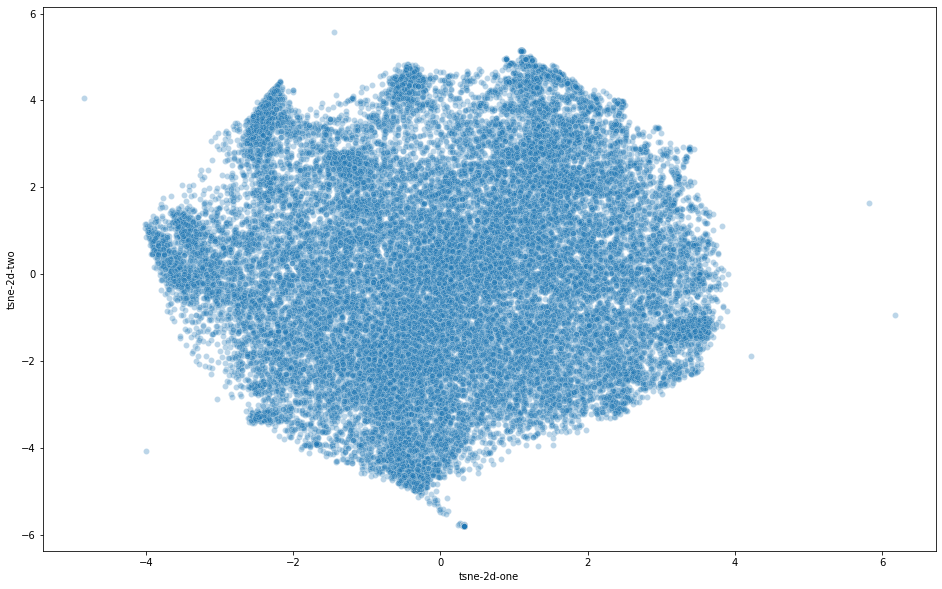

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame()

df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

## TODO

* Map politicians and parties to the vectors
* Use them as a hue on the plot
* Apply a clustering algorithm
* Tweak the PCA/T-SNE to improve separation between clusters

## Save model

In [121]:
d2v_model.save('models/uk_politics_d2v_'+today+'.model')

INFO - 12:50:42: Doc2Vec lifecycle event {'fname_or_handle': 'models/uk_politics_d2v_2021-10-09.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-10-09T12:50:42.171919', 'gensim': '4.0.1', 'python': '3.7.11 (default, Jul 27 2021, 07:03:16) \n[Clang 10.0.0 ]', 'platform': 'Darwin-20.6.0-x86_64-i386-64bit', 'event': 'saving'}
INFO - 12:50:42: not storing attribute cum_table
INFO - 12:50:42: saved models/uk_politics_d2v_2021-10-09.model
